# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
class Config():
    training_dir = "./dataset/training/"
    testing_dir = "./dataset/testing/"
    train_batch_size = 64
    train_number_epochs = 100

# dataaug Augmentor

In [4]:
import numpy as np
import imgaug as ia
from PIL import Image

class Augmenter():

    def __init__(self, seq):
        self.seq = seq

    def __call__(self, img_and_annotation):

        normal_image = img_and_annotation[0]
        defect_image = img_and_annotation[1]
        box_annotation_dict = img_and_annotation[2]

        normal_image = np.array(normal_image)
        defect_image = np.array(defect_image)
        
        normal_image_aug, defect_image_aug, bbs_aug = self.augment_image(normal_image, defect_image, box_annotation_dict, self.seq)
        
        normal_image_aug = Image.fromarray(normal_image_aug)
        defect_image_aug = Image.fromarray(defect_image_aug)

        return normal_image_aug, defect_image_aug, bbs_aug

    def augment_image(self, normal_image, defect_image, box_annotation_dict, seq):
        bbs = self.transform_imgaug_style_boxes(box_annotation_dict)
        seq_det = seq.to_deterministic()

        normal_image_aug = seq_det.augment_images([normal_image])[0]
        defect_image_aug = seq_det.augment_images([defect_image])[0]
        bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]
        bbs_aug = bbs_aug.remove_out_of_image().cut_out_of_image()
        augmented_box = self.transofrm_annotation_information_style(box_annotation_dict, bbs_aug)

        return normal_image_aug, defect_image_aug, augmented_box

    @staticmethod
    def transofrm_annotation_information_style(box_annotation_dict, bbs_aug):
        assert isinstance(box_annotation_dict, dict)

        box_annotation_keys = box_annotation_dict.keys()
        assert "size" in box_annotation_keys
        assert "object" in box_annotation_keys

        size_tag_keys = box_annotation_dict["size"].keys()
        assert "width" in size_tag_keys
        assert "height" in size_tag_keys
        assert "depth" in size_tag_keys

        assert isinstance(box_annotation_dict["object"], list)
        for _object in box_annotation_dict["object"]:
            _object_keys = _object.keys()
            assert "name" in _object_keys
            assert "xmin" in _object_keys
            assert "ymin" in _object_keys
            assert "xmax" in _object_keys
            assert "ymax" in _object_keys

        assert isinstance(bbs_aug, ia.BoundingBoxesOnImage)

        objects = box_annotation_dict["object"]
        objects.clear()

        for i in range(len(bbs_aug.bounding_boxes)):
            augmented_box = bbs_aug.bounding_boxes[i]
            objects.append(
                {
                    "name": augmented_box.label,
                    "xmin": augmented_box.x1,
                    "ymin": augmented_box.y1,
                    "xmax": augmented_box.x2,
                    "ymax": augmented_box.y2
                }
            )

        return box_annotation_dict

    @staticmethod
    def transform_imgaug_style_boxes(box_annotation_dict):
        assert isinstance(box_annotation_dict, dict)

        box_annotation_keys = box_annotation_dict.keys()
        assert "size" in box_annotation_keys
        assert "object" in box_annotation_keys

        size_tag_keys = box_annotation_dict["size"].keys()
        assert "width" in size_tag_keys
        assert "height" in size_tag_keys
        assert "depth" in size_tag_keys

        assert isinstance(box_annotation_dict["object"], list)
        for _object in box_annotation_dict["object"]:
            _object_keys = _object.keys()
            assert "name" in _object_keys
            assert "xmin" in _object_keys
            assert "ymin" in _object_keys
            assert "xmax" in _object_keys
            assert "ymax" in _object_keys

        image_width = int(box_annotation_dict["size"]["width"])
        image_height = int(box_annotation_dict["size"]["height"])

        bbs = ia.BoundingBoxesOnImage([], shape=(image_height, image_width))

        for _object in box_annotation_dict["object"]:
            name = _object["name"]
            xmin = int(_object["xmin"])
            ymin = int(_object["ymin"])
            xmax = int(_object["xmax"])
            ymax = int(_object["ymax"])
            bbs.bounding_boxes.append(ia.BoundingBox(x1=xmin,
                                                     x2=xmax,
                                                     y1=ymin,
                                                     y2=ymax,
                                                     label=name))

        return bbs

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [5]:
import os
import sys
from PIL import Image

IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', 'webp']
LABEL_EXTENSIONS = ['.xml']

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
        extensions (iterable of strings): extensions to consider (lowercase)
    Returns:
        bool: True if the filename ends with one of given extensions
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)


class DefectDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.folder = self._find_each_folder(root)
        self.root = root
        self.transform = transform
        self.samples = self.load_data()
        self.classes = ["defect"]
        
    def load_data(self):
        datas = list()
        
        directory = os.path.expanduser(self.root)
        
        for target in sorted(self.folder.keys()):
            d = os.path.join(directory, target)
            
            imgs = dict()
            label = None
            for a in os.scandir(d):
                name = a.name.split(".")[0]
                ext = a.name.split(".")[-1]
                
                if ext == "tif":
                    imgs[name] = os.path.join(d, a.name)
                
                elif ext == "xml":
                    label = os.path.join(d, a.name)
                
            datas.append([imgs, label])
        
        return datas
    
    def __getitem__(self, index):
        imgs, label = self.samples[index]
        label = self._parse_voc(label)
        
        normal_img = self.pil_loader(imgs["normal"])
        defect_img = self.pil_loader(imgs["defect"])
        
        if self.transform:
            normal_img, defect_img, label = self.transform([normal_img, defect_img, label])
        
        label = self._convert_box_label_to_yolo_label(label, self.classes)
        
        return normal_img, defect_img, label
    
    def __len__(self):
        return len(self.samples)
    
    def pil_loader(self, path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    
    def _find_each_folder(self, dir):
        
        if sys.version_info >= (3, 5):
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return class_to_idx
    
    def _convert_box_label_to_yolo_label(self, label, classes_list):
        assert isinstance(label, dict)
        assert isinstance(classes_list, list)
        for cls in classes_list:
            assert isinstance(cls, str)

        root_keys = label.keys()
        size_keys = label["size"].keys()
        number_of_objects = len(label["object"])

        assert "size" in root_keys
        assert "object" in root_keys
        assert "width" in size_keys
        assert "height" in size_keys
        
        if number_of_objects == 0:
            print("here")
            return []

        yolo_label = list()

        image_size = {
            "width": float(label["size"]["width"]),
            "height": float(label["size"]["height"]),
        }

        for _object in label["object"]:
            _object_keys = _object.keys()
            assert "name" in _object_keys
            assert "xmin" in _object_keys
            assert "ymin" in _object_keys
            assert "xmax" in _object_keys
            assert "ymax" in _object_keys

            name = _object["name"]
            cls = float(classes_list.index(name))
            box_coordinate = {
                "xmin": float(_object["xmin"]),
                "ymin": float(_object["ymin"]),
                "xmax": float(_object["xmax"]),
                "ymax": float(_object["ymax"]),
            }

            yolo_coordinate = self._convert_coordinate(image_size, box_coordinate)
            yolo_coordinate.insert(0, cls)
            yolo_label.append(yolo_coordinate)

        return yolo_label
    
    @staticmethod
    def _parse_voc(annotation_path):
        import xml.etree.ElementTree as Et
        assert isinstance(annotation_path, str)

        xml_file = open(annotation_path, "r")
        tree = Et.parse(xml_file)

        element_list = list()
        for elem in tree.iter():
            element_list.append(elem.tag)

        assert "size" in element_list
        assert "width" in element_list
        assert "height" in element_list
        assert "object" in element_list
        assert "name" in element_list
        assert "bndbox" in element_list
        assert "xmin" in element_list
        assert "ymin" in element_list
        assert "xmax" in element_list
        assert "ymax" in element_list

        result = dict()
        root = tree.getroot()

        size_tag = root.find("size")

        result["size"] = {
            "width": size_tag.find("width").text,
            "height": size_tag.find("height").text,
            "depth": size_tag.find("depth").text
        }

        result["object"] = list()

        objects = root.findall("object")
        assert objects

        for _object in objects:

            result["object"].append({
                "name": _object.find("name").text,
                "xmin": _object.find("bndbox").find("xmin").text,
                "ymin": _object.find("bndbox").find("ymin").text,
                "xmax": _object.find("bndbox").find("xmax").text,
                "ymax": _object.find("bndbox").find("ymax").text
            })

        return result
    
    @staticmethod
    def _convert_coordinate(image_size, box_coordinate):
        image_size_keys = image_size.keys()
        box_coordinate_keys = box_coordinate.keys()
        assert "width" in image_size_keys
        assert "height" in image_size_keys
        assert "xmin" in box_coordinate_keys
        assert "ymin" in box_coordinate_keys
        assert "xmax" in box_coordinate_keys
        assert "ymax" in box_coordinate_keys
        assert isinstance(image_size, dict)
        assert isinstance(box_coordinate, dict)
        assert isinstance(image_size["width"], float)
        assert isinstance(image_size["height"], float)
        assert isinstance(box_coordinate["xmin"], float)
        assert isinstance(box_coordinate["ymin"], float)
        assert isinstance(box_coordinate["xmax"], float)
        assert isinstance(box_coordinate["ymax"], float)

        x_of_box = (box_coordinate["xmin"] + box_coordinate["xmax"]) / 2.0
        y_of_box = (box_coordinate["ymin"] + box_coordinate["ymax"]) / 2.0
        width_of_box = box_coordinate["xmax"] - box_coordinate["xmin"]
        height_of_box = box_coordinate["ymax"] - box_coordinate["ymin"]

        relative_x_of_center = x_of_box / image_size["width"]
        relative_y_of_center = y_of_box / image_size["height"]
        relative_box_width = width_of_box / image_size["width"]
        relative_box_height = height_of_box / image_size["height"]

        return [relative_x_of_center, relative_y_of_center,
                relative_box_width, relative_box_height]


In [28]:
from imgaug import augmenters as iaa


# Augmentation Demo
seq = iaa.Sequential([
            iaa.Crop(percent=(0.1)),
            #iaa.Multiply((1.2, 1.5)),  # change brightness, doesn't affect BBs
            #iaa.Affine(
            #    translate_px={"x": 3, "y": 10},
            #    scale=(0.9, 0.9)
            #),  # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
            #iaa.AdditiveGaussianNoise(scale=0.01 * 255),
            #iaa.Affine(rotate=(-45, 40)),
            #iaa.Sharpen(alpha=(0.1, 0.4)),
            #iaa.Fliplr(0.5)
            ])

#seq = iaa.Sometimes(0.5, iaa.Crop(percent=(0.4)))
seq = iaa.Sequential([iaa.Crop(percent=(0.3))])
composed = transforms.Compose([Augmenter(seq)])

[15, 13, 25, 27, 3, 9, 2, 14, 29, 10, 17, 1, 20, 11, 7, 12, 28, 21, 22, 8, 16, 6, 24, 18, 19, 26, 0, 4, 23, 5]
[[0.0, 0.4305555555555556, 0.6371527777777778, 0.375, 0.4340277777777778]]


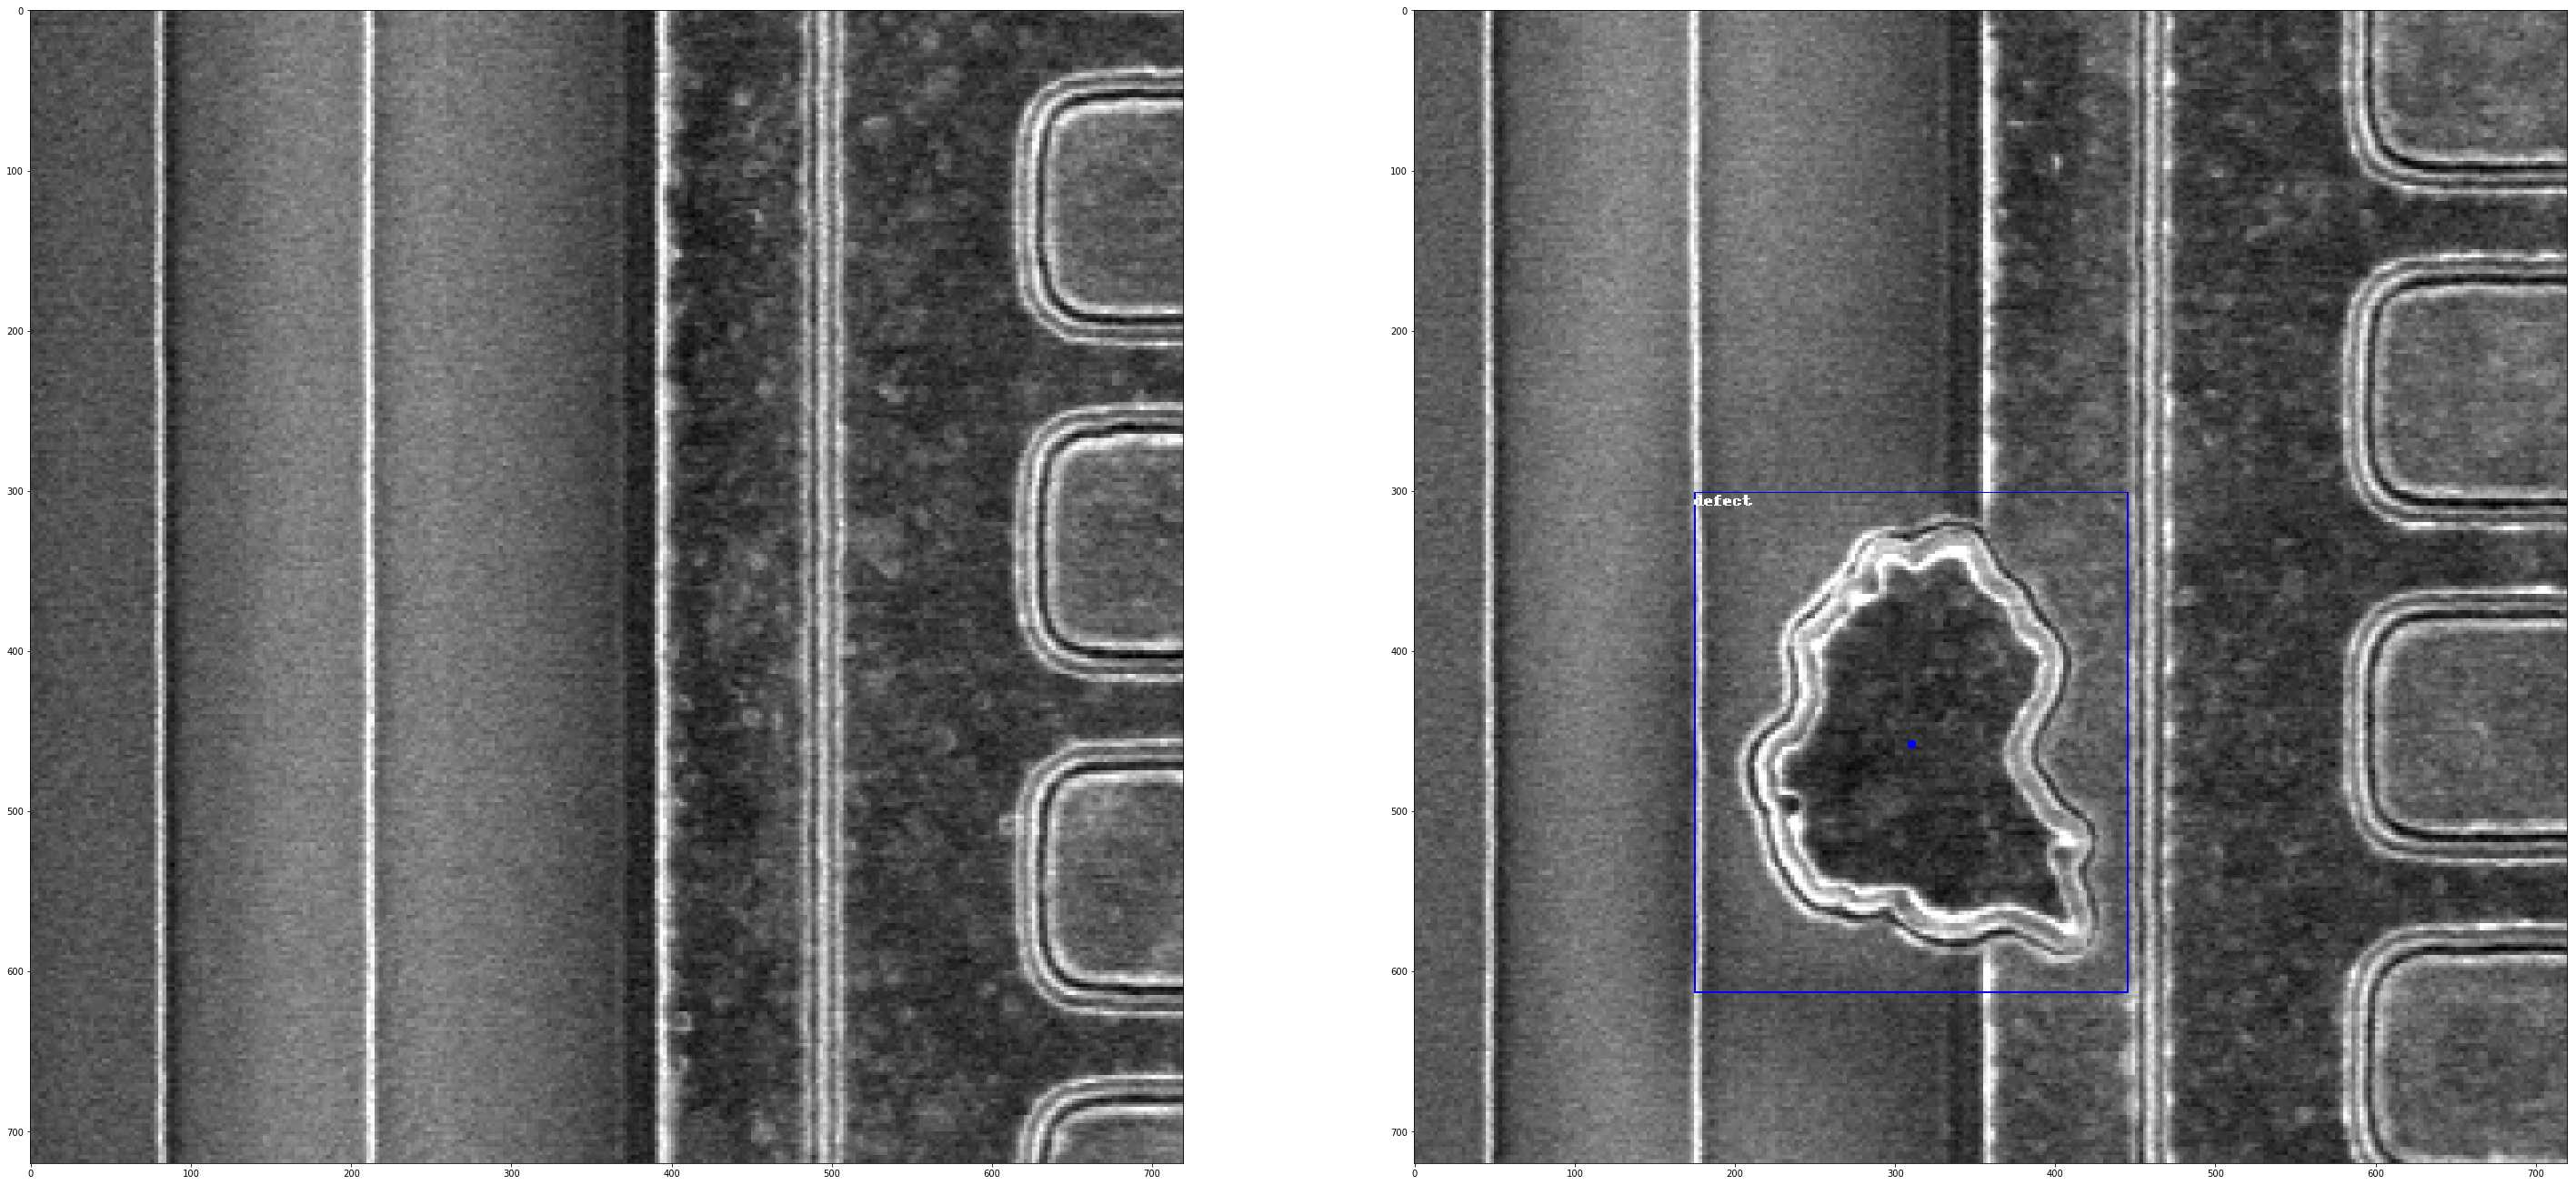

In [34]:
from PIL import ImageDraw
import random

def convert_yolo_label_to_box_label(coordinate, image_size, classes_list):
    assert isinstance(coordinate, list)
    assert len(coordinate) == 5
    for element in coordinate:
        assert isinstance(element, float)
    assert isinstance(image_size, tuple)
    assert isinstance(classes_list, list)
    for cls in classes_list:
        isinstance(cls, str)

    image_width, image_height = image_size

    cls = classes_list[int(coordinate[0])]
    x_of_center = int(coordinate[1] * image_width)
    y_of_center = int(coordinate[2] * image_height)
    width = coordinate[3] * image_width
    height = coordinate[4] * image_height

    xmin = int(x_of_center - (width / 2))
    ymin = int(y_of_center - (height / 2))
    xmax = int(xmin + width)
    ymax = int(ymin + height)

    return [cls, xmin, ymin, xmax, ymax]

def draw_yolo_information(draw_image_obj, coordinate, image_size, classes_list):
    assert isinstance(draw_image_obj, ImageDraw.ImageDraw)
    assert isinstance(image_size, tuple)
    assert isinstance(coordinate, list)
    assert len(coordinate) == 5
    for element in coordinate:
        assert isinstance(element, float)

    image_width, image_height = image_size

    x_of_center = int(coordinate[1] * image_width)
    y_of_center = int(coordinate[2] * image_height)

    cls, xmin, ymin, xmax, ymax = \
        convert_yolo_label_to_box_label(coordinate, image_size, classes_list)

    draw_image_obj.rectangle(((xmin, ymin), (xmax, ymax)), outline="blue")
    draw_image_obj.ellipse(((x_of_center - 2, y_of_center - 2),
                  (x_of_center + 2, y_of_center + 2)),
                 fill='blue')
    draw_image_obj.text((xmin, ymin), cls)

dataset = DefectDataset(root=Config.training_dir, transform=composed)
print(dataset)
index = [i for i in range(len(dataset))]

figsize = (50, 50)
random.shuffle(index)

print(index)

for j in range(1):
    i = index[j]
    normal_image, defect_image, target = dataset.__getitem__(i)
    
    draw = ImageDraw.Draw(defect_image)

    if len(target) != 0:
        for coordinate in target:
            draw_yolo_information(draw, coordinate, defect_image.size, ["defect"])

    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    plt.imshow(normal_image)
    plt.subplot(1,2,2)
    plt.imshow(defect_image)
    print(target)
    plt.show()
    plt.close()
    


In [8]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [ ]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [ ]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

